In [49]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import os
import re
import random
from random import shuffle
#import cmudictloss = criteon(logits, y)

import torch
from transformers import BertTokenizer, BertModel, BertConfig,BertForSequenceClassification, AdamW
from transformers import AutoModel, AutoConfig, AutoTokenizer, get_cosine_schedule_with_warmup

# from transformers import TFGPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm

In [21]:
standard = False
eda_ = False

In [22]:
scaler = StandardScaler()
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train['excerpt'] = train['excerpt'].apply(lambda x: x.replace('\n',''))

print("train shape: ", train.shape)
print("test shape: ", test.shape)

train shape:  (2834, 6)
test shape:  (7, 4)


In [23]:
array = list(range(len(train))) 
np.random.shuffle(array)
val = train.iloc[array[:100],]
train = train.iloc[array[100:],]

if standard:
    target_ = scaler.fit_transform(np.expand_dims(train['target'].to_numpy(),axis=1))
    train['target'] = np.squeeze(target_)

In [24]:
print("train shape: ", train.shape)
train.head(2)

train shape:  (2734, 6)


,id,url_legal,license,excerpt,target,standard_error
2269,9a4a22f12,NaN,NaN,On the farms utensils and furniture were gener...,-0.124091,0.481089
2081,0f32c1315,NaN,NaN,"In 1803, Mr. Jefferson, being then President o...",-1.382990,0.447929


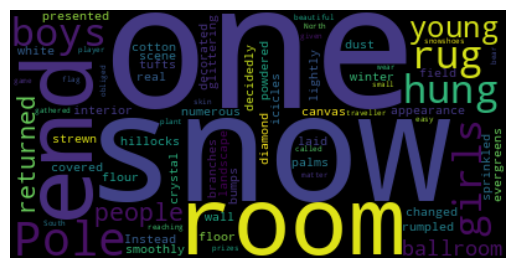

In [25]:
# train
text = train.loc[0, 'excerpt']

#Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

#Display the Generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

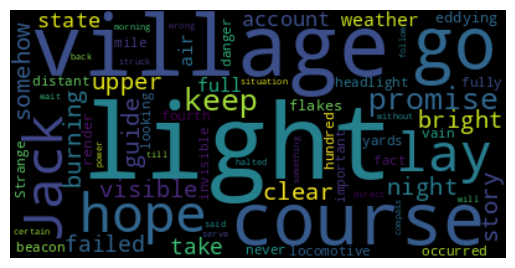

In [26]:
# test
text = test.loc[0, 'excerpt']

#Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

#Display the Generated image:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

NLTK --> https://www.nltk.org/index.html

In [11]:
from nltk.corpus import wordnet

In [14]:
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line


def synonym_replacement(words, n):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)


########################################################################
# Random deletion
# Randomly delete words from the sentence with probability p
########################################################################

def random_deletion(words, p):

	#obviously, if there's only one word, don't delete it
	if len(words) == 1:
		return words

	#randomly delete words with probability p
	new_words = []
	for word in words:
		r = random.uniform(0, 1)
		if r > p:
			new_words.append(word)

	#if you end up deleting all words, just return a random word
	if len(new_words) == 0:
		rand_int = random.randint(0, len(words)-1)
		return [words[rand_int]]

	return new_words

########################################################################
# Random swap
# Randomly swap two words in the sentence n times
########################################################################

def random_swap(words, n):
	new_words = words.copy()
	for _ in range(n):
		new_words = swap_word(new_words)
	return new_words

def swap_word(new_words):
	random_idx_1 = random.randint(0, len(new_words)-1)
	random_idx_2 = random_idx_1
	counter = 0
	while random_idx_2 == random_idx_1:
		random_idx_2 = random.randint(0, len(new_words)-1)
		counter += 1
		if counter > 3:
			return new_words
	new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
	return new_words

########################################################################
# Random insertion
# Randomly insert n words into the sentence
########################################################################

def random_insertion(words, n):
	new_words = words.copy()
	for _ in range(n):
		add_word(new_words)
	return new_words

def add_word(new_words):
	synonyms = []
	counter = 0
	while len(synonyms) < 1:
		random_word = new_words[random.randint(0, len(new_words)-1)]
		synonyms = get_synonyms(random_word)
		counter += 1
		if counter >= 10:
			return
	random_synonym = synonyms[0]
	random_idx = random.randint(0, len(new_words)-1)
	new_words.insert(random_idx, random_synonym)
    
    
def eda(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=1):
	
	sentence = get_only_chars(sentence)
	words = sentence.split(' ')
	words = [word for word in words if word is not '']
	num_words = len(words)
	
	augmented_sentences = []
	num_new_per_technique = int(num_aug/4)+1

	#sr
	if (alpha_sr > 0):
		n_sr = max(1, int(alpha_sr*num_words))
		for _ in range(num_new_per_technique):
			a_words = synonym_replacement(words, n_sr)
			augmented_sentences.append(' '.join(a_words))

	#ri
	if (alpha_ri > 0):
		n_ri = max(1, int(alpha_ri*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_insertion(words, n_ri)
			augmented_sentences.append(' '.join(a_words))

	#rs
	if (alpha_rs > 0):
		n_rs = max(1, int(alpha_rs*num_words))
		for _ in range(num_new_per_technique):
			a_words = random_swap(words, n_rs)
			augmented_sentences.append(' '.join(a_words))

	#rd
	if (p_rd > 0):
		for _ in range(num_new_per_technique):
			a_words = random_deletion(words, p_rd)
			augmented_sentences.append(' '.join(a_words))

	augmented_sentences = [get_only_chars(sentence) for sentence in augmented_sentences]
	shuffle(augmented_sentences)

	#trim so that we have the desired number of augmented sentences
	if num_aug >= 1:
		augmented_sentences = augmented_sentences[:num_aug]
	else:
		keep_prob = num_aug / len(augmented_sentences)
		augmented_sentences = [s for s in augmented_sentences if random.uniform(0, 1) < keep_prob]

	#append the original sentence
	augmented_sentences.append(sentence)

	return augmented_sentences

<>:134: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:134: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_3965480/3911037912.py:134: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  words = [word for word in words if word is not '']


In [42]:
num_aug = 1
random.seed(1)
train_aug = train['excerpt'].tolist()
target_aug = train['target'].tolist()

print("Train Input shape:", np.array(train_aug).shape)
print("Target Input shape:", np.array(target_aug).shape)

Train Input shape: (2734,)
Target Input shape: (2734,)


In [28]:
if eda_:
    for i, line in tqdm(enumerate(train.to_numpy())):
        label = line[4]  # 
        sentence = line[3]
    
        aug_sentences = eda(sentence)
        train_aug.append(aug_sentences)
        target_aug.append(label)

In [29]:
print("Output shape:", np.array(train_aug).shape)

Output shape: (2734,)


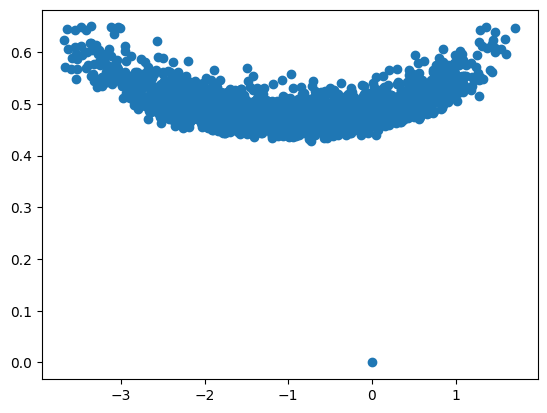

In [31]:
plt.scatter(
    train['target'].to_numpy(), 
    train['standard_error'].to_numpy()
)   # 0.0 - > std 0.64967129

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: ", device)

device:  cuda


## Bert Model

In [33]:
model_path = 'bert-base-uncased'
tokenizer= BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(
    model_path, num_labels=1
)
model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [34]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Optimizer -- Adam

In [36]:
optim = AdamW(
    model.parameters(), lr=5e-5, weight_decay=1e-4
)      #  params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,

#### StepLR

Decays the learning rate of each parameter group by gamma every step_size epochs. Notice that such decay can happen simultaneously with other changes to the learning rate from outside this scheduler. When last_epoch=-1, sets initial lr as lr.

In [37]:
scheduler = torch.optim.lr_scheduler.StepLR(
    optim, step_size=3, gamma=0.1, last_epoch=-1
)

## DataLoader

In [40]:
class CRPDataLoader(torch.utils.data.Dataset):
    """
    CommonLit Readability Prize (CRP) DataLoader
    """
    def __init__(self, train_tokens, labels):
        self.train_tokens = train_tokens
        self.labels = labels

    def __getitem__(self, idx):
        #train_tokens= tokenizer.batch_encode_plus(self.text_list,max_length=512,padding='longest',truncation=True)
        item = {key: torch.tensor(val[idx]) for key, val in self.train_tokens.items()}
        item['labels'] = torch.tensor(self.labels[idx],dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

In [66]:
# ---- Train Dataset
if eda_:
    print("--- eda_ ----")
    train_tokens = tokenizer.batch_encode_plus(
        train_aug, max_length=512, padding='longest', truncation=True
    )
    train_dataset = CRPDataLoader(train_tokens, target_aug)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  
else:
    print("--- else ---")
    train_tokens = tokenizer.batch_encode_plus(
        train['excerpt'].tolist(), max_length=512, padding='longest', truncation=True
    )
    train_dataset = CRPDataLoader(train_tokens, train.target.values)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)  # 4-> 32

--- else ---


In [60]:
# ---- Validate Dataset
val_tokens = tokenizer.batch_encode_plus(
    val['excerpt'].tolist(), max_length=512, padding='longest', truncation=True
)
val_dataset = CRPDataLoader(val_tokens, val.target.values)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [61]:
# ---- Test Dataset
test_tokens = tokenizer.batch_encode_plus(
    test['excerpt'].tolist(), max_length=512, padding='longest', truncation=True
)
test['target'] = 0
test_dataset = CRPDataLoader(test_tokens, test.target.values)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [62]:
lr_scheduler = get_cosine_schedule_with_warmup(
    optim,num_warmup_steps=0, num_training_steps=int(len(train)/10)
)   # 10 *

## Train

In [67]:
total_test_preds = []
val_rmse = []

for epoch in range(3):
    for batch in tqdm(train_loader):
        # Assign to device
        input_ids = batch['input_ids'].to(device)
        
        # Forward pass
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).reshape(attention_mask.shape[0], -1)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        # Backward, optimize, and zero Gradients
        optim.zero_grad(set_to_none=True) 
        loss = outputs[0]  # MSELossBackward

        loss.backward()
        optim.step()
        if lr_scheduler:
            lr_scheduler.step()

    total_preds = []
    # iterate over batches
    for step, batch in enumerate(val_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).reshape(attention_mask.shape[0], -1)
        with torch.no_grad():

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)        
            
            preds = outputs[1].detach().cpu().numpy()
            if standard:
                preds = scaler.inverse_transform(preds)
                
            total_preds.extend(preds-labels.detach().cpu().numpy())

    val_rmse.append(np.sqrt(np.mean(np.square(total_preds))))
    print("Epoch ", epoch, " RMSE: ", np.sqrt(np.mean(np.square(total_preds))))
    
    # test
    total_preds = []
    for step, batch in enumerate(test_loader):
        print(step)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).reshape(attention_mask.shape[0], -1)
        with torch.no_grad():

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)        

            preds = outputs[1].detach().cpu().numpy()
            if standard:
                    preds = scaler.inverse_transform(preds)

            total_test_preds.append(preds)
    
    print(total_test_preds)

  0%|          | 0/2734 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 7.78 GiB of which 12.88 MiB is free. Including non-PyTorch memory, this process has 7.70 GiB memory in use. Of the allocated memory 6.63 GiB is allocated by PyTorch, and 82.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF